# RRAM Relaxation 1/f Fitting

This notebook contains the fitting for 1/f RRAM relaxation data across three technologies (A, B, C). It loads and processes the measurements taken for each technology to enable fitting and understanding of the data.

In [1]:
# Imports
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.stats

%config InlineBackend.figure_format = 'svg'

## Load the technology and its settings

Below, choose which technology to load data and settings for:

In [2]:
# Choose technology here
TECH = 'C'

# Load settings for technology
with open(f"data/tech{TECH}/settings.json") as sfile:
    settings = json.load(sfile)

## Load the conductance data vs. time
Here, we will load the full dataset of conductance over time at room temperature to look at the 1/f behaviors of cells.

In [3]:
# Load data for technology
colnames = ["addr", "time", "r", "g"]
data = pd.read_csv(f"data/tech{TECH}/relaxdata.tsv.gz", names=colnames, sep='\t')
data = data[data["addr"] % 2 == 0] # use only even addresses (odd addresses have weird behavior due to 2T2R architecture)
data["time"] -= data.groupby("addr")["time"].transform("first") # start from t=0 for each addr
data["gi"] = data.groupby("addr")["g"].transform("first") # get initial conductance each addr was programmed to
data["range"] = np.int32(data["gi"] / settings["gmax"] * 32) # get initial conductance range each addr was programmed to
data.head()

,addr,time,r,g,gi,range
0,10354,0.000000,2.082326e+06,4.802322e-07,4.802322e-07,0
1,10354,0.006997,5.372904e+06,1.861191e-07,4.802322e-07,0
2,10354,0.016950,5.513018e+06,1.813889e-07,4.802322e-07,0
3,10354,0.023997,5.602565e+06,1.784897e-07,4.802322e-07,0
4,10354,0.030978,5.537474e+06,1.805878e-07,4.802322e-07,0


addr = 0
fs = 1002.7023667223364
Fit 1 coefficient = 1.4472813483281853e-13
Fit 2 coefficient = 1.8433039488970646e-13


No handles with labels found to put in legend.


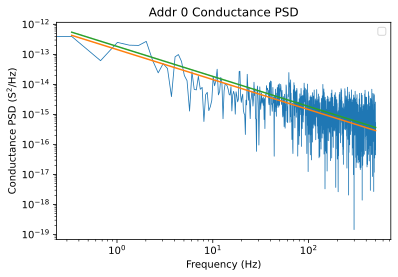

addr = 8


No handles with labels found to put in legend.


fs = 1002.4627151051556
Fit 1 coefficient = 1.3168102227014474e-14
Fit 2 coefficient = 8.637952881849321e-15


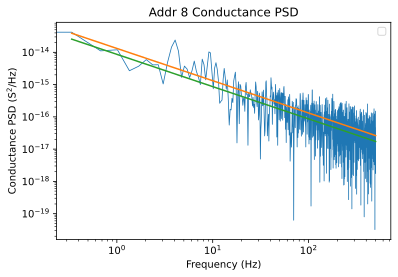

No handles with labels found to put in legend.


addr = 16
fs = 1002.5825265922313
Fit 1 coefficient = 6.989865947065756e-13
Fit 2 coefficient = 2.701161688436972e-14


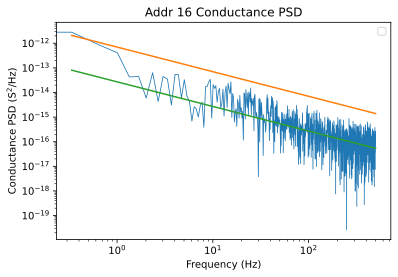

No handles with labels found to put in legend.


addr = 24
fs = 1002.3429322501933
Fit 1 coefficient = 1.4987604143833985e-13
Fit 2 coefficient = 2.971860395859409e-14


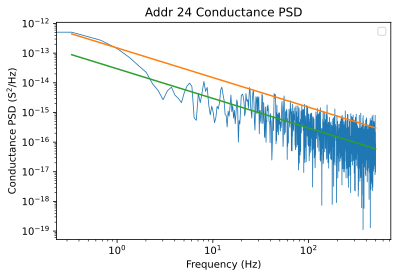

In [4]:
# Plot some 1/f PSDs
for a in np.array(range(0, 32, 8)) + (80000 if TECH == 'A' else 0):
    # Select which addr is being studied
    print(f"addr = {a}")
    d = data[(data["addr"] == a) & (data["time"] < 10)]
    gvals = d.drop_duplicates(subset=["time"]).sort_values(["time"])

    # Compute sampling time
    fs = 1/np.median(np.gradient(gvals['time']))
    print(f"fs = {fs}")
    freq, p = scipy.signal.welch(gvals["g"], fs, nperseg=len(gvals["g"]))

    # Fit functions
    fitfn1 = lambda f, c: c / f
    fitfn2 = lambda logf, c: c - logf
    fit1 = scipy.optimize.curve_fit(fitfn1, freq[1:], p[1:])
    fit2 = scipy.optimize.curve_fit(fitfn2, np.log10(freq[1:]), np.log10(p[1:]))
    print(f"Fit 1 coefficient = {fit1[0][0]}")
    print(f"Fit 2 coefficient = {10**fit2[0][0]}")

    # Plot PSD and fits
    plt.legend()
    plt.plot(freq, p, linewidth=0.8)
    plt.plot(freq[1:], fitfn1(freq[1:], fit1[0][0]))
    plt.plot(freq[1:], 10**fitfn2(np.log10(freq[1:]), fit2[0][0]))
    plt.title(f"Addr {a} Conductance PSD")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Conductance PSD (S$^2$/Hz)")
    plt.xscale("log")
    plt.yscale("log")
    plt.show()

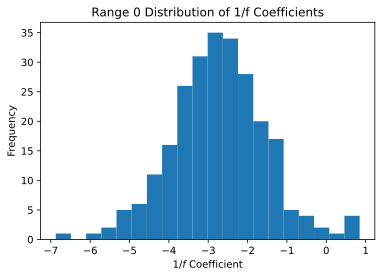

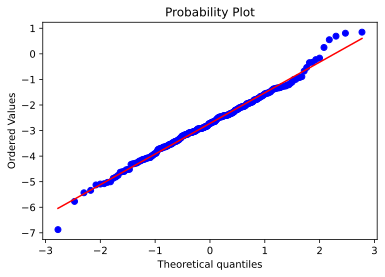

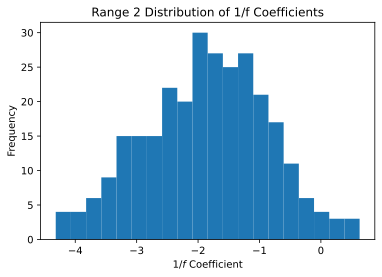

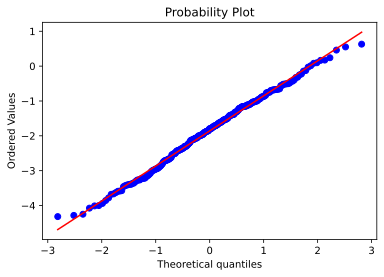

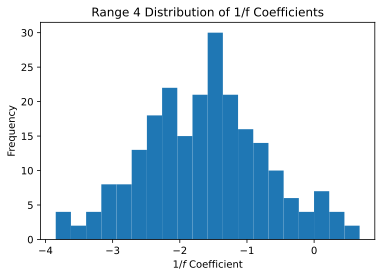

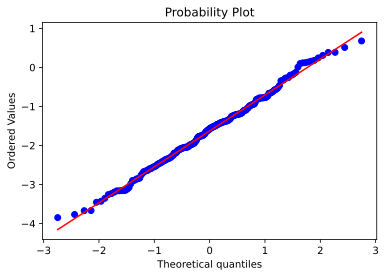

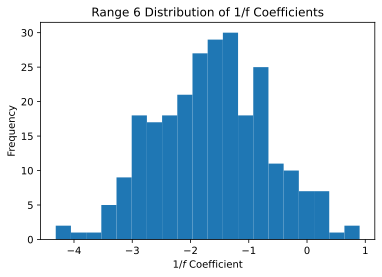

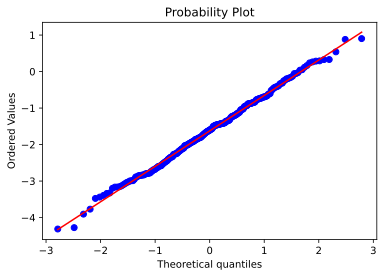

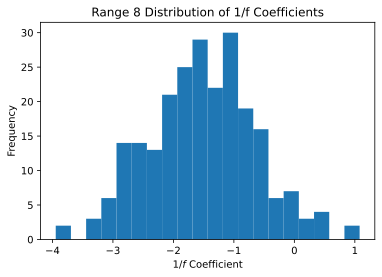

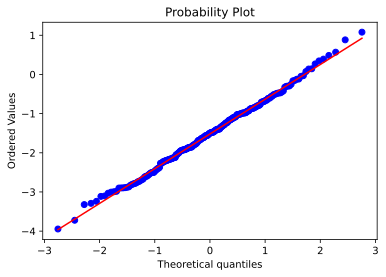

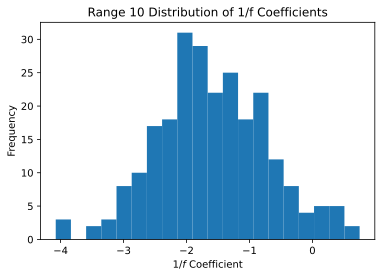

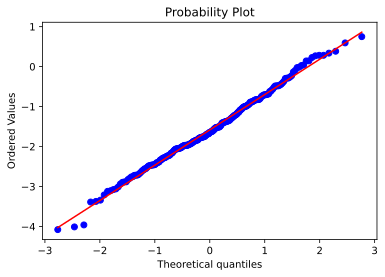

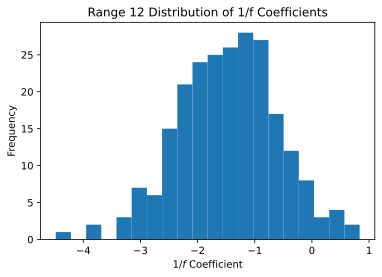

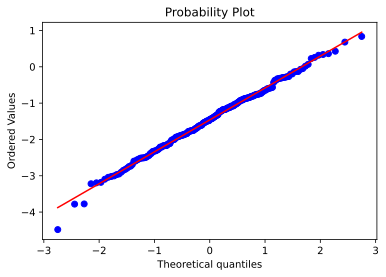

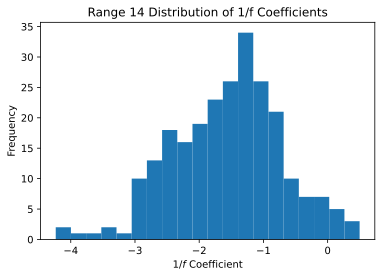

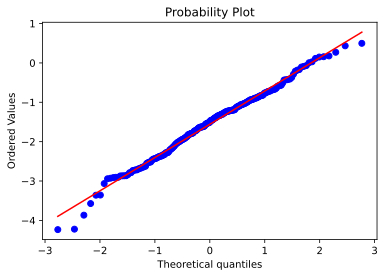

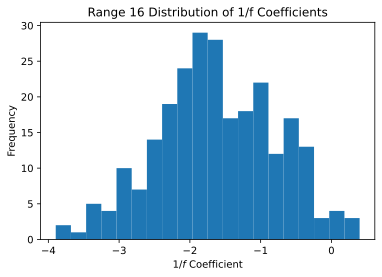

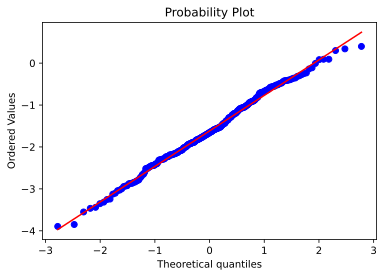

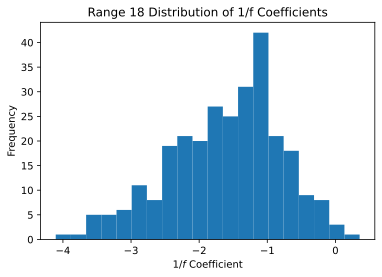

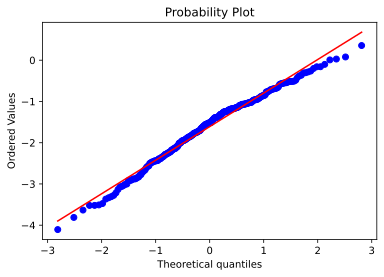

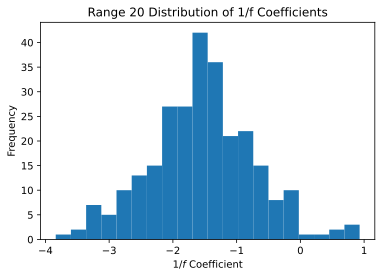

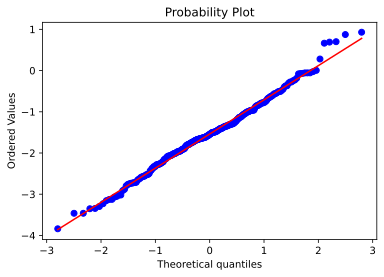

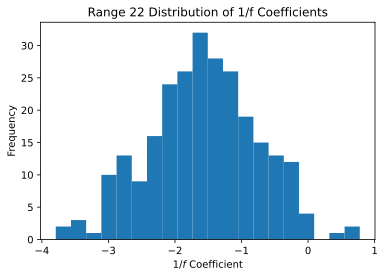

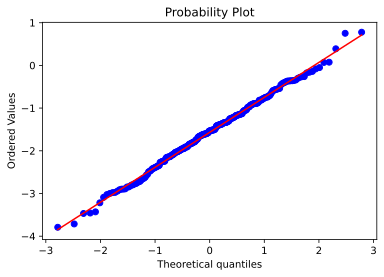

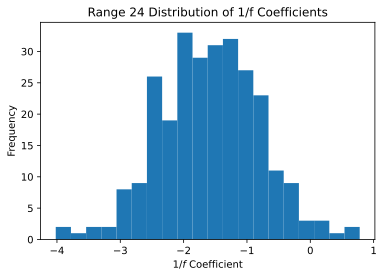

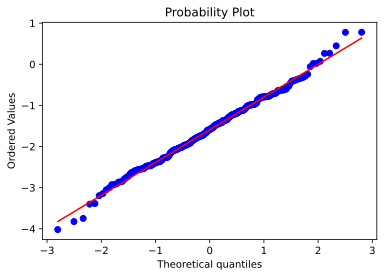

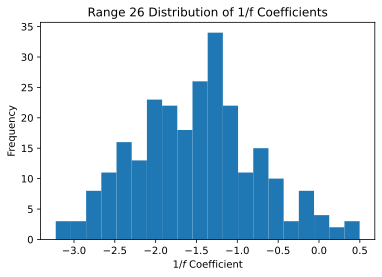

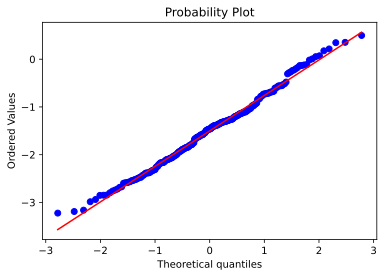

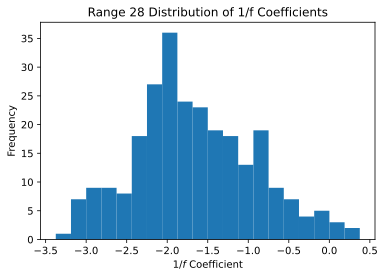

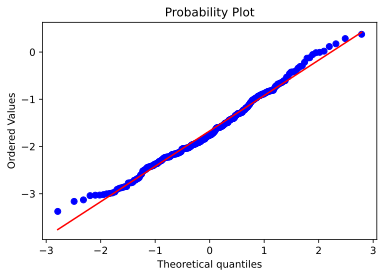

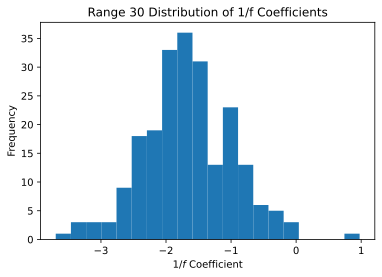

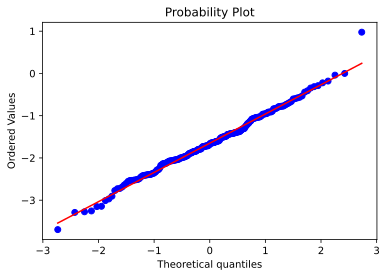

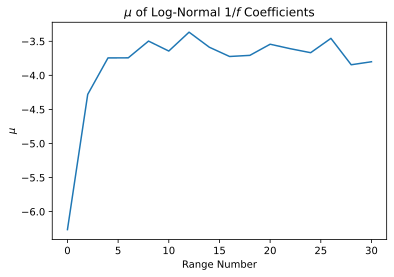

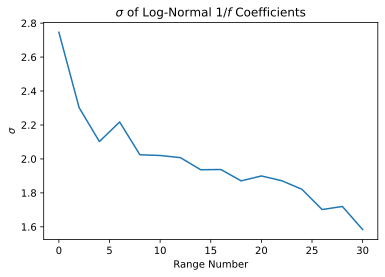

In [7]:
# 1/f coefficient statistics
fitfn = lambda f, c: c / f
fitfnloglog = lambda logf, c: c - logf

# Noise fitting function
def noise_fit(gvals, loglogfit=False):
    gvals = gvals.drop_duplicates(subset=['time']).sort_values(["time"])
    freq, p = scipy.signal.welch(gvals["g"]*10**6, fs=1/np.median(np.gradient(gvals["time"])), nperseg=len(gvals["g"]))
    if loglogfit:
        popt, pcov = scipy.optimize.curve_fit(fitfnloglog, np.log10(freq[1:]), np.log10(p[1:]))
        return 10**popt[0]
    else:
        popt, pcov = scipy.optimize.curve_fit(fitfn, freq[1:], p[1:])
        return popt[0]

# Log-normal fitting of 1/f coefficients
mus, sigmas = [], []
ranges = np.arange(0, 32, 2)
for r in ranges:
    # Fit 1/f coefficients
    coefs = data[(data["range"]==r) & (data["time"] < 10)].groupby("addr")[["g", "time"]].apply(noise_fit)
    
    # Plot log-normal histogram
    plt.hist(np.log10(coefs), bins=20)
    plt.title(f"Range {r} Distribution of 1/f Coefficients")
    plt.xlabel("$1/f$ Coefficient")
    plt.ylabel("Frequency")
    plt.show()

    # Plot log-normal fit
    scipy.stats.probplot(np.log10(coefs), dist='norm', plot=plt, fit=True)
    plt.show()

    # Get log-normal fit parameters
    mu, sigma = scipy.stats.norm.fit(np.log(coefs))
    mus.append(mu)
    sigmas.append(sigma)

# Plot mus
plt.plot(ranges, mus)
plt.title(f"$\mu$ of Log-Normal $1/f$ Coefficients")
plt.xlabel("Range Number")
plt.ylabel("$\mu$")
plt.show()

# Plot sigmas
plt.plot(ranges, sigmas)
plt.title(f"$\sigma$ of Log-Normal $1/f$ Coefficients")
plt.xlabel("Range Number")
plt.ylabel("$\sigma$")
plt.show()